In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

C:\Users\Payanshi\Anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create a custom collate function
def collate_fn(data):
    # Initialize empty tensors for each resolution
    resolution1_tensor = []
    resolution2_tensor = []
    resolution3_tensor = []
    
    # Traverse through each image in the data
    for image in data:
        transformer = transforms.ToPILImage()
        transformer1 = transforms.ToTensor()
        image_tensor = transformer1(transformer(image[0]))
        # Check the resolution of the image
        if (image_tensor.shape[1] == resolution1 & image_tensor.shape[2] == resolution1):
            resolution1_tensor.append(image)
#             resolution1_tensor = torch.cat((resolution1_tensor, image_tensor), 0)
        elif (image_tensor.shape[1] == resolution2 & image_tensor.shape[2] == resolution2):
            resolution2_tensor.append(image)
#             resolution2_tensor = torch.cat((resolution2_tensor, image_tensor), 0)
        elif (image_tensor.shape[1] == resolution3 & image_tensor.shape[2] == resolution3):
            resolution3_tensor.append(image)
#             resolution3_tensor = torch.cat((resolution3_tensor, image_tensor), 0)
            
    # Return the tensors for each resolution
    return resolution1_tensor, resolution2_tensor, resolution3_tensor

# Define the resolutions for the images
resolution1 = 32
resolution2 = 48
resolution3 = 64

In [3]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed,
                           augment=False,
                           valid_size=0.2,
                           shuffle=True,
                           show_sample=False,
                           num_workers=1,
                           pin_memory=True):
    """
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

    # define transforms
    valid_transform = transforms.Compose([
#             transforms.Grayscale(num_output_channels=1),
#             transforms.Resize((28,28)),
            transforms.ToTensor(),
            normalize
        ])
    if augment:
        train_transform = transforms.Compose([
#             transforms.Grayscale(num_output_channels=1),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
#             transforms.Resize((28,28)),
            transforms.ToTensor(),
            normalize
        ])
    else:
        train_transform = transforms.Compose([
#             transforms.Grayscale(num_output_channels=1),
#             transforms.Resize((28,28)),
            transforms.ToTensor(),
            normalize
        ])

    # load the dataset
    train_dataset = datasets.ImageFolder(root=data_dir,transform=train_transform)
    valid_dataset = datasets.ImageFolder(root=data_dir,transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                    batch_size=batch_size, sampler=train_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory,collate_fn=collate_fn)

    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                    batch_size=batch_size, sampler=valid_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory,collate_fn=collate_fn)


    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(train_dataset, 
                                                    batch_size=batch_size, 
                                                    shuffle=shuffle, 
                                                    num_workers=num_workers,
                                                    pin_memory=pin_memory,collate_fn=collate_fn)
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy()
        plot_images(X, labels)

    return (train_loader, valid_loader)

In [4]:
def get_test_loader(data_dir, 
                    batch_size,
                    shuffle=True,
                    num_workers=1,
                    pin_memory=True):
    """
    Utility function for loading and returning a multi-process 
    test iterator over the MNIST dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

    # define transform
    transform = transforms.Compose([
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Resize((28,28)),
        transforms.ToTensor(),
        normalize
    ])

    dataset = datasets.ImageFolder(data_dir,transform=transform)

    data_loader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=batch_size, 
                                              shuffle=shuffle, 
                                              num_workers=num_workers,
                                              pin_memory=pin_memory,collate_fn=collate_fn)

    return data_loader

In [5]:
train_loader, valid_loader = get_train_valid_loader('mnist-varres/train/..',
                           batch_size = 16,
                           random_seed = 100,
                           augment=False,
                           valid_size=1/6,
                           shuffle=True,
                           show_sample=False,
                           num_workers=0,
                           pin_memory=True)

In [6]:
test_loader = get_test_loader('mnist-varres/test/..', 
                    batch_size=10,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True)

In [7]:
loaders = {'train': train_loader,
          'test': test_loader,
          'val': valid_loader} 

In [8]:
class CNN(nn.Module):
    def __init__(self, input_channels, num_classes, N):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, N, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2)

#         self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.global_pool = nn.AdaptiveMaxPool2d(1)
        self.linear = nn.Linear(N, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.global_pool(x)
        x = x.view(x.size(0),-1)
#         x = torch.max(torch.max(x,-1).values,-1)[0]
        x = self.linear(x)

        return x

In [9]:
cnn = CNN(3,10,81)
print(cnn)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 81, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveMaxPool2d(output_size=1)
  (linear): Linear(in_features=81, out_features=10, bias=True)
)


### Loss Function and Optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=0.001)
# optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [12]:
from torch.autograd import Variable
num_epochs = 10

def train(num_epochs,cnn,loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    total_step_val = len(loaders['val'])
    
    train_loss_list = []
    train_mean_loss_list = []
    train_acc_list = []
#     train_correct = 0
#     train_total = 0
#     val_correct = 0
#     val_total = 0
    val_acc_list = []
 
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        val_correct = 0
        val_total = 0
        mean_loss = []
        for step in range(0,total_step):            
            tensor1, tensor2, tensor3 = next(iter(loaders['train']))
            tensors = [tensor1, tensor2, tensor3]           
            for j, tensor in enumerate(tensors):                
                if(len(tensor)==0):
                    continue
                images = [x[0] for x in tensor]
                labels = [x[1] for x in tensor]
                images = torch.stack(images)
                labels = torch.tensor(labels)
                
                outputs = cnn(images)           
                loss = criterion(outputs, labels)
                # clear gradients for this training step   
                optimizer.zero_grad()           
                # backpropagation, compute gradients 
                loss.backward()    
                # apply gradients             
                optimizer.step()  
                
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
                train_acc =100.*train_correct/train_total
                
                mean_loss.append(loss.item())

            if (step+1) % 1000 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}' 
                       .format(epoch + 1, num_epochs, step + 1, total_step, loss.item(), train_acc))
                pass 
        train_mean_loss_list.append(np.mean(mean_loss))
        train_loss_list.append(loss.item())
        train_acc_list.append(train_acc)
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for step in range(0,total_step_val):
                    tensor1, tensor2, tensor3 = next(iter(loaders['val']))
                    tensors = [tensor1, tensor2, tensor3]
                    for j, tensor in enumerate(tensors):
        #                 N = resolutions[j]
        #                 for i, (images, labels) in enumerate(tensor):
                        if(len(tensor)==0):
                            continue

                        images = [x[0] for x in tensor]
                        labels = [x[1] for x in tensor]
                        images = torch.stack(images)
                        labels = torch.tensor(labels)
                        # calculate outputs by running images through the network
                        val_outputs = cnn(images)
                        # the class with the highest energy is what we choose as prediction
                        _, val_predicted = torch.max(val_outputs.data, 1)
                        val_total += labels.size(0)
                        val_correct += (val_predicted == labels).sum().item()
                        val_acc =100.*val_correct/val_total
                        
        val_acc_list.append(val_acc)

        print(f'Accuracy of the network on the 10000 test images: {100 * val_correct // val_total} %')                   
        pass    
    pass
    return(train_loss_list, train_acc_list, val_acc_list, train_mean_loss_list)
        

train_loss_list, train_acc_list, val_acc_list, train_mean_loss_list = train(num_epochs, cnn, loaders)

Epoch [1/10], Step [1000/3646], Loss: 0.1623, Acc: 84.8187
Epoch [1/10], Step [2000/3646], Loss: 0.4978, Acc: 85.2719
Epoch [1/10], Step [3000/3646], Loss: 0.1194, Acc: 85.3812
Accuracy of the network on the 10000 test images: 85 %
Epoch [2/10], Step [1000/3646], Loss: 0.4201, Acc: 85.9437
Epoch [2/10], Step [2000/3646], Loss: 0.9096, Acc: 85.6125
Epoch [2/10], Step [3000/3646], Loss: 0.1255, Acc: 85.6208
Accuracy of the network on the 10000 test images: 86 %
Epoch [3/10], Step [1000/3646], Loss: 0.4395, Acc: 85.8563
Epoch [3/10], Step [2000/3646], Loss: 0.4902, Acc: 85.8812
Epoch [3/10], Step [3000/3646], Loss: 0.4934, Acc: 85.7938
Accuracy of the network on the 10000 test images: 85 %
Epoch [4/10], Step [1000/3646], Loss: 0.1183, Acc: 85.5750
Epoch [4/10], Step [2000/3646], Loss: 0.4911, Acc: 85.6312
Epoch [4/10], Step [3000/3646], Loss: 1.4062, Acc: 85.5583
Accuracy of the network on the 10000 test images: 85 %
Epoch [5/10], Step [1000/3646], Loss: 0.3924, Acc: 85.4625
Epoch [5/10],

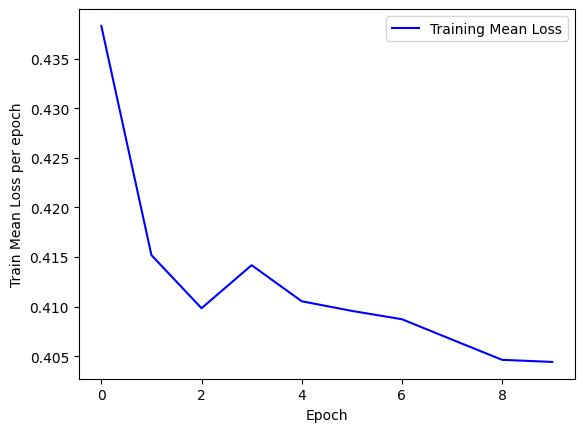

In [13]:
# Get training and test loss histories
df = pd.DataFrame(list(zip(train_loss_list, train_acc_list, val_acc_list,train_mean_loss_list )),columns =['Train_Loss', 'Train_Accuracy', 'Val_Accuracy', 'Train_Mean_Loss'])
training_mean_loss = df['Train_Mean_Loss']

# Create count of the number of epochs
epoch_count = num_epochs #(len(x_train)) #range(1, len(training_loss) + 1

# Visualize loss history
plt.plot(training_mean_loss, 'b')
plt.legend(['Training Mean Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Mean Loss per epoch')
plt.savefig("Training_Mean_Loss_Q16_v4.png")
plt.show();

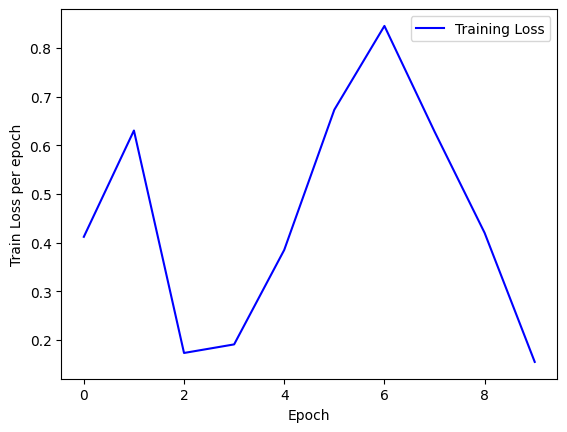

In [14]:
# Get training and test loss histories
df = pd.DataFrame(list(zip(train_loss_list, train_acc_list, val_acc_list )),columns =['Train_Loss', 'Train_Accuracy', 'Val_Accuracy'])
training_loss = df['Train_Loss']

# Create count of the number of epochs
epoch_count = num_epochs #(len(x_train)) #range(1, len(training_loss) + 1

# Visualize loss history
plt.plot(training_loss, 'b')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Loss per epoch')
plt.savefig("Training_Loss_Q16_v4.png")
plt.show();

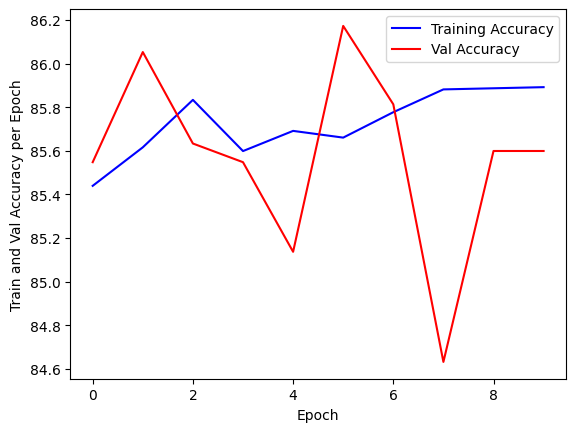

In [15]:
# Get training and test loss histories
# df = pd.DataFrame(list(zip(loss_list, acc_list)),columns =['Train_Accuracy', 'Val_Accuracy'])
training_acc = df['Train_Accuracy']
val_acc = df['Val_Accuracy']

# Create count of the number of epochs
epoch_count = num_epochs #(len(x_train)) #range(1, len(training_loss) + 1

# Visualize loss history
plt.plot(training_acc, 'b')
plt.plot(val_acc, 'r-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Train and Val Accuracy per Epoch')
plt.savefig("Accuracy_Q16_v4.png")
plt.show();

In [16]:
total = 0 
correct = 0
total_step_test = len(loaders['test'])
with torch.no_grad():
    for step in range(0,total_step_test):
            tensor1, tensor2, tensor3 = next(iter(loaders['test']))
            tensors = [tensor1, tensor2, tensor3]
            for j, tensor in enumerate(tensors):
                if(len(tensor)==0):
                    continue

                images = [x[0] for x in tensor]
                labels = [x[1] for x in tensor]
                images = torch.stack(images)
                labels = torch.tensor(labels)
                # calculate outputs by running images through the network
                test_outputs = cnn(images)
                # the class with the highest energy is what we choose as prediction
                _, test_predicted = torch.max(test_outputs.data, 1)
                total += labels.size(0)
                correct += (test_predicted == labels).sum().item()
                
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 85.64714285714285 %


In [17]:
total = 0 
correct = 0
total_step_test = len(loaders['val'])
with torch.no_grad():
    for step in range(0,total_step_test):
            tensor1, tensor2, tensor3 = next(iter(loaders['val']))
            tensors = [tensor1, tensor2, tensor3]
            for j, tensor in enumerate(tensors):
                if(len(tensor)==0):
                    continue

                images = [x[0] for x in tensor]
                labels = [x[1] for x in tensor]
                images = torch.stack(images)
                labels = torch.tensor(labels)
                # calculate outputs by running images through the network
                test_outputs = cnn(images)
                # the class with the highest energy is what we choose as prediction
                _, test_predicted = torch.max(test_outputs.data, 1)
                total += labels.size(0)
                correct += (test_predicted == labels).sum().item()
                
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 86.00171232876713 %
